# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, June 18, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1chi_j6mzK1iL7cemhmp6gATknqx1p1e1

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1. Make sure that you are actually modifying the dataframe df.

Like numpy arrays and torch tensors, pandas data frames can be sliced. For example, we can display the first 3 rows of the data frame (3 records) below.

In [ ]:
import numpy as np

# Select the right columns
#selected = df[['age','yredu','capgain','caploss','workhr']]

# Show the first three rows
#selected[:3]

# Isolate each column and find the max, min, and average value using numpy functions 

## Age
age = df[['age']]

print("For age... Max: {}, Min: {}, Average: {}".format(np.amax(age)[0], np.amin(age)[0], np.average(age)))

## Years of Education
yredu = df[['yredu']]

print("For Years of Education... Max: {}, Min: {}, Average: {}".format(np.amax(yredu)[0], np.amin(yredu)[0], np.average(yredu)))

## Capital Gain
capgain = df[['capgain']]

print("For Capital Gain... Max: {}, Min: {}, Average: {}".format(np.amax(capgain)[0], np.amin(capgain)[0], np.average(capgain)))

## Capital Loss
caploss = df[['caploss']]

print("For Capital Loss... Max: {}, Min: {}, Average: {}".format(np.amax(caploss)[0], np.amin(caploss)[0], np.average(caploss)))

## Work Hours per Week
workhr = df[['workhr']]

print("For Work Hours per Week... Max: {}, Min: {}, Average: {}".format(np.amax(workhr)[0], np.amin(workhr)[0], np.average(workhr)))

For age... Max: 90, Min: 17, Average: 38.58164675532078
For Years of Education... Max: 16, Min: 1, Average: 10.0806793403151
For Capital Gain... Max: 99999, Min: 0, Average: 1077.6488437087312
For Capital Loss... Max: 4356, Min: 0, Average: 87.303829734959
For Work Hours per Week... Max: 99, Min: 1, Average: 40.437455852092995


#### Only Run this ONCE

In [ ]:
# In order to normalize, we would apply a division across all the rows within the column. 
# I'm assuming there's no negative numbers and zero is the lowest number. 
# I will divide entire column by the maximum value. 


df['age'] = df['age']/np.amax(age)[0]
df['yredu'] = df['yredu']/np.amax(yredu)[0]
df['capgain'] = df['capgain']/np.amax(capgain)[0]
df['caploss'] = df['caploss']/np.amax(caploss)[0]
df['workhr'] = df['workhr']/np.amax(workhr)[0]

# Check with first 3 rows
print(np.amax(age)[0])
print(df['age'][:3])

90
0    0.433333
1    0.555556
2    0.422222
Name: age, dtype: float64


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
np.sum(df["sex"] == " Male")

21790

In [ ]:
females = np.sum(df['sex'] == ' Female')
male = np.sum(df['sex'] == ' Male')
total = females + male

print("Percent Females: {}%".format(females/total*100))
print("Percent Male: {}%".format(male/total*100))

Percent Females: 33.07945087681583%
Percent Male: 66.92054912318419%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(df_not_missing.shape)
print(df_with_missing.shape)
print(missing.shape)

(30718, 11)
(1843, 11)
(32561,)


In [ ]:
print("Percent Records Removed: {}%".format(df_with_missing.shape[0]/missing.shape[0]*100))

Percent Records Removed: 5.660145572924664%


**1843 files contained missing features. 5.66 percent of files were removed.**

### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing['work']))

{' Federal-gov', ' Private', ' State-gov', ' Without-pay', ' Local-gov', ' Self-emp-inc', ' Self-emp-not-inc'}


**The possible values are:**

```
{' Private', ' Self-emp-inc', ' Without-pay', ' Federal-gov', ' State-gov', ' Self-emp-not-inc', ' Local-gov'} ```



We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.433333,0.8125,0.02174,0.0,0.404040,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.555556,0.8125,0.00000,0.0,0.131313,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.422222,0.5625,0.00000,0.0,0.404040,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(data.shape)

(30718, 57)


**The shape of "data" is: (30718, 57). That's 30718 rows and 57 columns. The 57 columns includes all the possible values of every feature in "df_not_missing".**

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->

    a = np.argmax(onehot)  #find index of max value in the one hot array
    out = cat_values[feature][a]  # based on the index, look up the respective value with the dictionary
    return out


In [ ]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
# What is cat_index and cat_values?

print(cat_index)
print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


** cat_values provides a list of all possible values for every feature in a well-organized list. cat_index provides the index each feature set begins on. **



### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
b = datanp.shape[0]

print(b)
train = 0.7 * b
val = 0.15 * b
test = 0.15 * b
sum = train + val + test
print(sum)
print(train, val, test)

30718
30718.0
21502.6 4607.7 4607.7


In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo, use panda library to shuffle
shuffled_data = data.sample(frac=1, random_state=50)
shuffled_datas = shuffled_data.values.astype(np.float32)

# Sort the data into the respective sections using index splitting:
train_data = shuffled_datas[0:21502]
val_data = shuffled_datas[21502:26109]
test_data = shuffled_datas[26109:30718]

There are 21502 training files, 4607 validation, and 4609 testing files. 

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(21502, 57)
(4607, 57)
(4609, 57)


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 29), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(29,22)
        )
        self.decoder = nn.Sequential(
            nn.Linear(22, 29), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(29, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

** The sigmoid activation function is used to ensure the output of our missing value feature is normalized between 0 and 1. **

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import time

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    #Generate a seed
    torch.manual_seed(42)

    # Define the Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/test loss/err accuracy
    iters, losses, train_acc, val_acc = [], [], [], []


################################# Train Loop ###################################
    start_time = time.time()
    print("Training Started...")
    n = 0 # to count number of iterations 
    for epoch in range(num_epochs):
        print("This is epoch:{}".format(epoch))
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n+=1

        # Calculate the statistics
        iters.append(n)
        losses.append(float(loss)/batch_size)                 # compute average loss
        train_acc.append(get_accuracy(model, train_loader))   # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))       # compute valiation accuracy
        print(epoch, train_acc[-1], val_acc[-1])

    #Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    return train_acc, val_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Training Started...
This is epoch:0
0 0.6036415217189098 0.5984009840098401
This is epoch:1
1 0.6098269928378756 0.6063960639606396
This is epoch:2
2 0.6192059653365578 0.6163085160263367
This is epoch:3
3 0.6135398257526432 0.6119672961435497
This is epoch:4
4 0.6218413790965182 0.6192750162795746
This is epoch:5
5 0.6126716894552445 0.6105202228492873
This is epoch:6
6 0.6256007193129322 0.6243397728094928
This is epoch:7
7 0.626228567885158 0.6239780044859272
This is epoch:8
8 0.6231745884103804 0.6217350408798206
This is epoch:9
9 0.6345998821815025 0.6324072064250055
This is epoch:10
10 0.6339100238737482 0.6291874683452717
This is epoch:11
11 0.6271742163519672 0.6260039070978946
This is epoch:12
12 0.6241434905280129 0.6251718399536936
This is epoch:13
13 0.6285539329674759 0.6261847912596773
This is epoch:14
14 0.6257479924348123 0.6218797482092469
This is epoch:15
15 0.6360261060986575 0.63309456623978
This is epoch:16
16 0.6338325117043376 0.6307068953042472
This is epoch:17


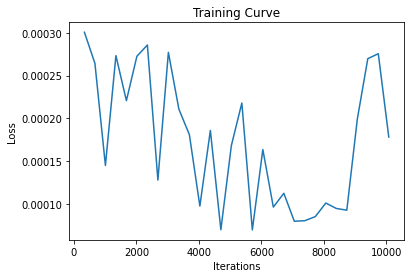

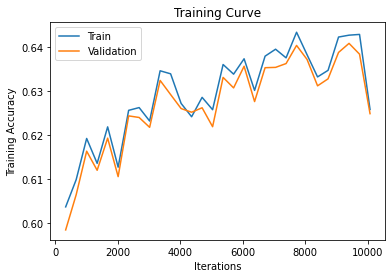

Final Training Accuracy: 0.6258100021703408
Final Validation Accuracy: 0.6248462484624846


([0.6036415217189098,
  0.6098269928378756,
  0.6192059653365578,
  0.6135398257526432,
  0.6218413790965182,
  0.6126716894552445,
  0.6256007193129322,
  0.626228567885158,
  0.6231745884103804,
  0.6345998821815025,
  0.6339100238737482,
  0.6271742163519672,
  0.6241434905280129,
  0.6285539329674759,
  0.6257479924348123,
  0.6360261060986575,
  0.6338325117043376,
  0.6373283105447555,
  0.6301351812234521,
  0.6379251542492171,
  0.6395064025051933,
  0.6375453446191052,
  0.6433665085418411,
  0.6382507053607417,
  0.6332046631321118,
  0.6347006480017363,
  0.6422735869531516,
  0.6426999038849099,
  0.6428704306576133,
  0.6258100021703408],
 [0.5984009840098401,
  0.6063960639606396,
  0.6163085160263367,
  0.6119672961435497,
  0.6192750162795746,
  0.6105202228492873,
  0.6243397728094928,
  0.6239780044859272,
  0.6217350408798206,
  0.6324072064250055,
  0.6291874683452717,
  0.6260039070978946,
  0.6251718399536936,
  0.6261847912596773,
  0.6218797482092469,
  0.633094

In [ ]:
## Sample Code from Lab 2
batch_size = 64
# Load the data
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = 1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, num_workers = 1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = 1)

#Initiate the encoder
encode5 = AutoEncoder()

train(encode5, train_loader, val_loader, num_epochs = 30, learning_rate = 0.01)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

I first began with the default values where epoch=30, lr=1e-4, batch_size = 32 and I didn't change my autoencoder that I set up. This provided a maximum validation accuracy of 61.28%. From that, I decided to increase batch_size and learning rate to see what occurs. I changed batch_size to 64 and lr = 0.01. This produced the graph below. 

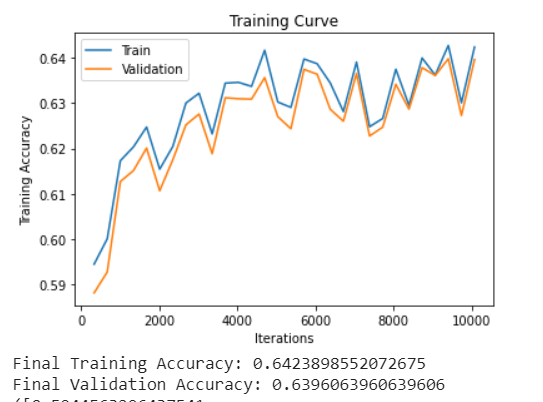

It seemed increasing the batch_size and increasing the learning rate helped to increase the validation accuracy. However, the learning rate seemed too big as the accuracy keeps jumping back and forth, as seen by the noisy graph. I kept epochs the same since the accuracy wasn't improving much beyond 8000 iterations. For the 3rd set, I tried with batch_size = 100 and lr = 0.006. My results are:

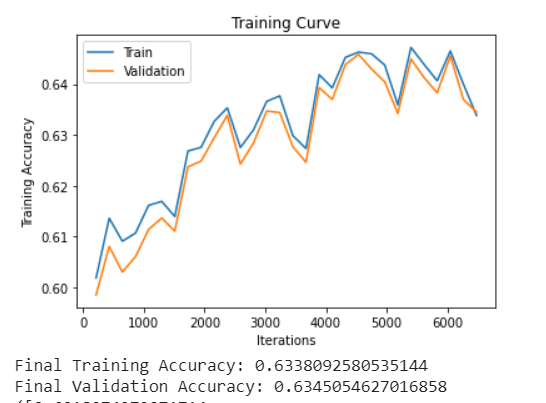

It seemed increasing batch_size and decreasing learning rate did not help much with validation accuracy... I will choose to change the architecture, perhaps decreasing the number of hidden units and increasing the number of linear layers. 

Original:
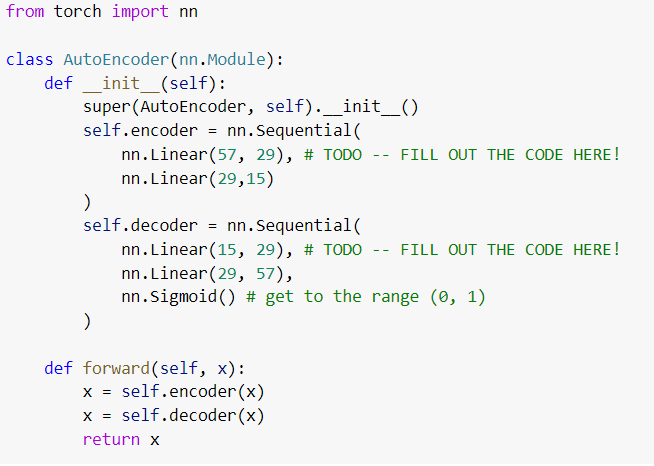

New: 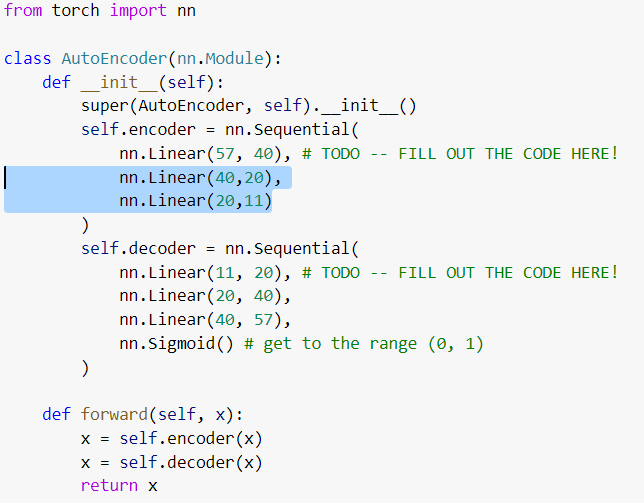

The new architecture achieved a best of: 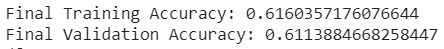

I will decide to stick to my original architecture and take batch_size = 64 and lr = 0.01, with all other hyperparameters same as the original. This is because that model achieved the highest validation accuracy. 

## Part 4. Testing [12 pt]

> Indented block



### Part (a) [2 pt]

Compute and report the test accuracy.

I will use the same training and get_accuracy functions but insert test_loader rather than val_loader. 


Training Started...
This is epoch:0
0 0.6094316807738815 0.6040807466898198
This is epoch:1
1 0.6167333271323597 0.6116055278199841
This is epoch:2
2 0.6043468824605464 0.60292308805441
This is epoch:3
3 0.6141521718909869 0.6109905216699226
This is epoch:4
4 0.6200585992000744 0.6155849793792055
This is epoch:5
5 0.619360989675379 0.6187685406265827
This is epoch:6
6 0.6051452578054755 0.6032848563779756
This is epoch:7
7 0.6157876786655505 0.6118949424788366
This is epoch:8
8 0.6086255542120113 0.6066493017871355
This is epoch:9
9 0.6147645180293306 0.6110990521669922
This is epoch:10
10 0.6228257836480328 0.6208306200709066
This is epoch:11
11 0.6153536105168511 0.6116055278199841
This is epoch:12
12 0.6042383654233715 0.6006077707835902
This is epoch:13
13 0.6091603881809444 0.6083134360755372
This is epoch:14
14 0.6229730567699129 0.6211923883944722
This is epoch:15
15 0.6233451151830838 0.621373272556255
This is epoch:16
16 0.6177099804669333 0.6151146805585703
This is epoch:17
1

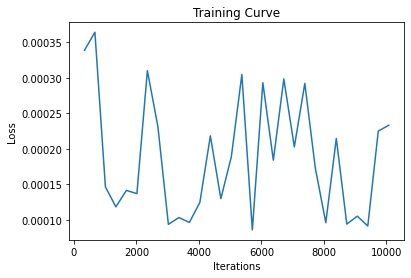

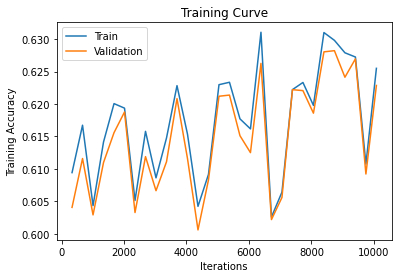

Final Training Accuracy: 0.6254922022757573
Final Validation Accuracy: 0.6228565226828738


([0.6094316807738815,
  0.6167333271323597,
  0.6043468824605464,
  0.6141521718909869,
  0.6200585992000744,
  0.619360989675379,
  0.6051452578054755,
  0.6157876786655505,
  0.6086255542120113,
  0.6147645180293306,
  0.6228257836480328,
  0.6153536105168511,
  0.6042383654233715,
  0.6091603881809444,
  0.6229730567699129,
  0.6233451151830838,
  0.6177099804669333,
  0.6161674882956624,
  0.6310498248224972,
  0.6025951074318668,
  0.6064242086007503,
  0.622213437509689,
  0.6233141103153195,
  0.6197873066071373,
  0.6310033175208508,
  0.6298018788949865,
  0.6278873283105447,
  0.6272362260874957,
  0.6107493876538617,
  0.6254922022757573],
 [0.6040807466898198,
  0.6116055278199841,
  0.60292308805441,
  0.6109905216699226,
  0.6155849793792055,
  0.6187685406265827,
  0.6032848563779756,
  0.6118949424788366,
  0.6066493017871355,
  0.6110990521669922,
  0.6208306200709066,
  0.6116055278199841,
  0.6006077707835902,
  0.6083134360755372,
  0.6211923883944722,
  0.621373272

In [ ]:
testcoder = AutoEncoder()

train(testcoder, train_loader, test_loader, num_epochs = 30, learning_rate = 0.01)

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
# Use cat_value indices and the one-hot to find the max. like sum it up and you'll find max out of the index range for each category
# These max values are the ones you are plugging in
# To compute the accuracy, 



```
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
```



In [ ]:
## To obtain the index of the max value in each feature:
def find_max_feature(df, feature): ## df is datanp
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    hot1 = df.sum(axis=0)[start_index:stop_index]  ## axis = 0 to get the columns to add up, so you just get a single onehot of all the columns summed together
    onehot_max_index = np.argmax(hot1)  ## find the max value in the onehot array and note down it's index
    return start_index + onehot_max_index #return the index of the most common value      

## To test our accuracy, we change all the values of the columns found by the "find_max_feature" to the most common value:
### We will use a method similar to "zero_out_feature" sample code
def change_max_values(records, feature, index):
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0  ## to set all to 0, thereby leaving no chance of array summing greater than 1
    records[:,index] = 1 ## set them positive for most common value
    return records

## The accuracy function, we will be comparing the original values to the ones created by "change_max_values":
def secure_base_accuracy(max_feature, data_loader):
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = change_max_values(inp.copy(), col, max_feature)
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [ ]:
# I will test the accuracy with one randomly selected feature from catcols:
aa = find_max_feature(datanp, "marriage")
print(aa)

14


In [ ]:
secure_base_accuracy(aa, train_loader)

0.23086224537252348

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**My baseline test accuracy was only 23%, this is durastically lower than my test accuracy of around 62%. **

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
# Take a subset of the original data, in this case the first row...
subset = torch.utils.data.Subset(test_data, [0])
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False) # load it
first_row = iter(testloader_subset) # present it
print(next(first_row))

tensor([[0.1889, 0.4375, 0.0000, 0.0000, 0.1616, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000]])


Looking at the max values, I can tell that this person is Young, mid 20s, half of the max amount of education years so like 8 years, works 16 hours per week, private work, never married, works in transport moving, education 11th grade, female, owns a child...

I don't think its very ethical for one to assume another's education level based on their other features. Individuals are unique and their life situations are also unique. They could be in jail and still earn a law degree while in there. Thus, I think it's unreasonable for a human to be able to guess because there is always bias involved, where the norm will influence judgement and produce possibly false results. 


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
## We will be using testloader_subset and plugging that into our model soon after training it. 
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = 1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, num_workers = 1)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False) # load it

final1 = AutoEncoder()

train(final1, train_loader, val_loader, num_epochs = 30, learning_rate = 0.01)

In [ ]:
first_row1 = next(iter(testloader_subset)) # present it
final1(first_row1)

tensor([[1.8549e-01, 3.7353e-01, 2.3377e-11, 5.2568e-08, 1.7166e-01, 9.7203e-23,
         4.5573e-07, 9.8639e-01, 8.3417e-09, 1.9532e-12, 4.1182e-15, 3.4511e-09,
         5.1277e-05, 1.3695e-05, 9.4233e-16, 1.9151e-05, 1.0000e+00, 3.4122e-15,
         6.2547e-18, 2.7663e-13, 4.5139e-06, 3.2590e-21, 2.7853e-08, 9.0616e-08,
         6.2613e-08, 9.0297e-07, 3.9224e-08, 1.5531e-08, 9.2352e-03, 8.2956e-05,
         3.2704e-04, 4.9260e-16, 1.0000e+00, 1.3178e-19, 1.0000e+00, 2.3841e-05,
         8.8834e-04, 4.1180e-03, 9.5480e-01, 3.2356e-05, 1.5534e-10, 9.7699e-23,
         4.3118e-11, 3.0650e-07, 6.0592e-04, 1.2819e-17, 2.5921e-04, 6.4772e-07,
         1.6157e-03, 1.6218e-26, 3.8369e-03, 6.9938e-06, 1.0000e+00, 2.3883e-03,
         6.3355e-08, 9.9700e-01, 2.9761e-03]], grad_fn=<SigmoidBackward>)

The model's prediction is: index 35 which is 11th grade and is accurate as this individual is indeed in 11th grade.. 

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
aaa = find_max_feature(datanp, "edu")
print(aaa)

44


Index 44 refers to Doctorate Degree in Education. 